In [43]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Definition der Dataframes:

In [44]:
df_walk = pd.read_json("normal_walk.json")

df_fall = pd.read_json("fall.json")

df_testFall = pd.read_json("test_fall.json")

In [45]:
df_walk.describe()

,time,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.560600e+04,1.560600e+04,15605.000000,15605.000000,15605.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.683269e+18,-6.919721e+02,0.051799,0.440262,0.023489,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.567039e+13,4.567039e+04,0.567014,1.009353,0.893979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.680417e+18,-2.852898e+06,-5.566208,-5.664675,-4.368199,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.683270e+18,1.962529e+01,-0.221366,-0.224200,-0.224045,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.683270e+18,3.925919e+01,0.022858,0.793248,0.062439,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.683270e+18,5.889272e+01,0.314255,1.077164,0.407181,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.683270e+18,7.852227e+01,4.551981,5.324697,4.855778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

In [47]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,2023-04-02 06:30:19.905724160,-2.852898e+06,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,2023-05-05 06:58:38.144353792,1.635376e-02,-0.770004,-0.392059,0.095901,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,2023-05-05 06:58:38.154418944,2.641895e-02,-0.801300,-0.401917,0.068222,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,2023-05-05 06:58:38.164484096,3.648413e-02,-0.832657,-0.412109,0.057846,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,2023-05-05 06:58:38.174548992,4.654907e-02,-0.863892,-0.420822,0.063507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
df_testFall = df_testFall.set_index('time')

In [49]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

In [50]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']
df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

df_walk_gyro = df_walk[df_walk['sensor'] == 'GyroscopeUncalibrated']
df_fall_gyro = df_fall[df_fall['sensor'] == 'GyroscopeUncalibrated']
df_testFall_gyro = df_testFall[df_testFall['sensor'] == 'GyroscopeUncalibrated']

df_walk_or = df_walk[df_walk['sensor'] == 'Orientation']
df_fall_or = df_fall[df_fall['sensor'] == 'Orientation']
df_testFall_or = df_testFall[df_testFall['sensor'] == 'Orientation']


In [51]:
df_fall_or.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]
df_testFall_acc = df_testFall_acc[['z','x','y']]

df_walk_gyro = df_walk_gyro[['z','x','y']]
df_fall_gyro = df_fall_gyro[['z','x','y']]
df_testFall_gyro = df_testFall_gyro[['z','x','y']]

df_walk_grav = df_walk_grav[['z','x','y']]
df_fall_grav = df_fall_grav[['z','x','y']]
df_testFall_grav = df_testFall_grav[['z','x','y']]

<AxesSubplot:xlabel='time'>

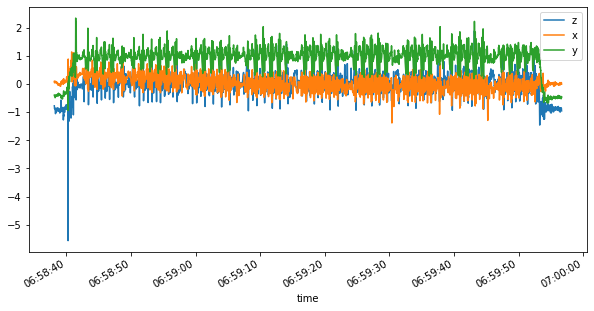

In [53]:
df_walk_acc.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

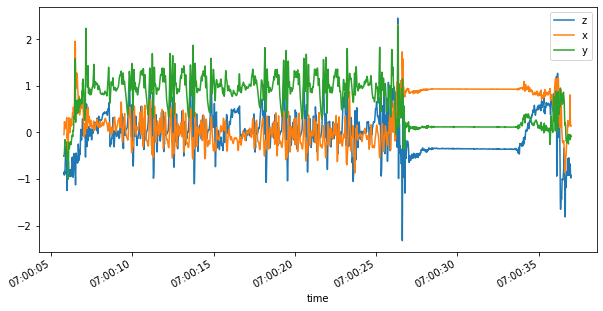

In [54]:
df_fall_acc.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

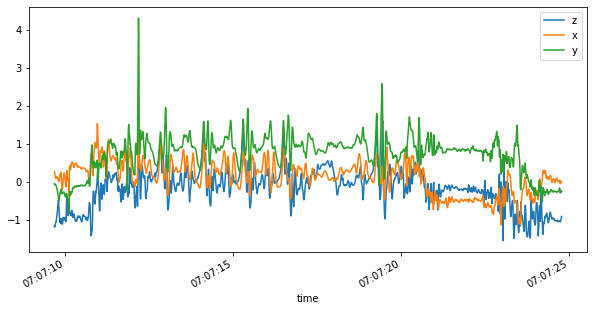

In [55]:
df_testFall_acc.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

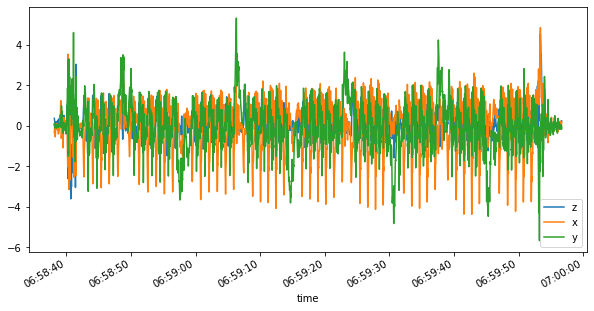

In [56]:
df_walk_gyro.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

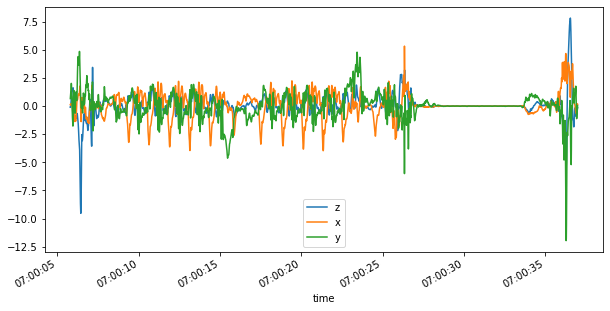

In [57]:
df_fall_gyro.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

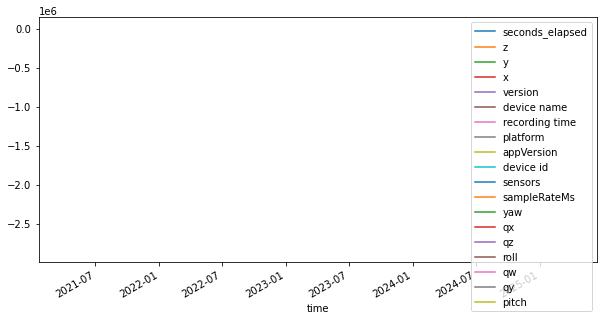

In [58]:
df_walk_or.plot(figsize=(10,5))

Create Training Data

In [69]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_testFall_acc['label'] = "fall"

df_combined = pd.concat([df_walk_acc, df_fall_acc])

In [60]:
#Anzahl der Reihen RowCount
len(df_walk_acc)
#Label hinzufügen

display(df_combined)

,z,x,y,label
time,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,walk
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,walk
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,walk
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,walk
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,walk
...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,fall
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,fall
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,fall


In [70]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df_combined):
    X_train, X_test = df_combined.iloc[train_index][['z','y','x']], df_combined.iloc[test_index][['z','y','x']]
    y_train, y_test = df_combined.iloc[train_index]["label"], df_combined.iloc[test_index]["label"]

    # Skalieren 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Passe Klassifikator an
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    # Evaluieren die Leistung des Klassifikators
    y_pred = clf.predict(X_test)
    #print(clf.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.29334067143643366
Accuracy: 0.02531645569620253


In [62]:
df_testFall_acc.head()

,z,x,y,label
time,,,,
2023-05-05 07:07:09.681482752,-1.156128,0.280060,-0.049332,fall
2023-05-05 07:07:09.691546880,-1.181564,0.249557,-0.037933,fall
2023-05-05 07:07:09.701610752,-1.159286,0.184860,-0.051285,fall
2023-05-05 07:07:09.711674880,-1.104019,0.131989,-0.072357,fall
2023-05-05 07:07:09.721737984,-1.056854,0.102814,-0.069427,fall


In [63]:
df_testFall_acc.describe()

,z,x,y
count,1501.000000,1501.000000,1501.000000
mean,-0.150339,0.137636,0.738855
std,0.496869,0.414868,0.498444
min,-1.537582,-1.123581,-0.813660
25%,-0.392334,-0.113159,0.532272
50%,-0.101776,0.188156,0.845291
75%,0.166306,0.404861,0.998993
max,1.614059,1.538834,4.314255


In [64]:
#Test via Konfusionsmatrix
y_pred = clf.predict(X_test)
accuracy = sk.metrics.confusion_matrix(y_test, y_pred)
print(accuracy)

[[  46 1771]
 [   0    0]]


Alternative Herangehensweise an die Erstellung von TestDaten: 
######################### Siehe Übung ######################### Code auf unser Beispiel anzupassen

In [65]:
import random

walk = df_walk_acc[['z','y','x']].values
fall = df_fall_acc[['z','y','x']].values

training_data = []
label_data = []

for x in range(20):
    start = random.randint(0, len(walk)-31)
    end = start + 30
    training_data.append(walk[start:end].flatten())
    label_data.append("walk")
    
    
for x in range(20):
    start = random.randint(0, len(fall)-31)
    end = start + 30
    training_data.append(fall[start:end].flatten())
    label_data.append("fall")

In [66]:
training_data

[array([-0.10185242,  0.85177612, -0.06062317, -0.09129333,  0.87062073,
        -0.05714417, -0.08642578,  0.89573669, -0.06684875, -0.05963135,
         0.91864014, -0.09411621,  0.00854492,  0.93403625, -0.11387634,
         0.11740112,  0.95184326, -0.11961365,  0.22583008,  0.96907043,
        -0.11314392,  0.24980164,  0.98477173, -0.07948303,  0.16369629,
         1.00975037, -0.03211975,  0.0231781 ,  1.05342102,  0.01635742,
        -0.07272339,  1.11044312,  0.06739807, -0.09538269,  1.1653595 ,
         0.10733032, -0.1164093 ,  1.22531128,  0.13435364, -0.15631104,
         1.28439331,  0.14328003, -0.17825317,  1.34115601,  0.13812256,
        -0.15078735,  1.36839294,  0.12849426, -0.05166626,  1.3535614 ,
         0.09391785,  0.13726807,  1.30522156,  0.01907349,  0.32046509,
         1.26641846, -0.08831787,  0.39578247,  1.25161743, -0.18983459,
         0.33448792,  1.23857117, -0.25622559,  0.25465393,  1.29266357,
        -0.22689819,  0.21943665,  1.38529968, -0.0

In [67]:
# Train
clf = RandomForestClassifier(random_state=0)
clf.fit(training_data, label_data)

RandomForestClassifier(random_state=0)

In [68]:
test = df_testFall_acc[['z','y','x']].values

test_data = []
test_label_data = []

for x in range(20):
    start = random.randint(0, len(test)-31)
    end = start + 30
    test_data.append(test[start:end].flatten())
    label_data.append("fall")

i = random.randint(0, len(test)-1)

test = test_data[i]

print("real Label:", test_label_data[i])

clf.predict([test_data])


IndexError: list index out of range

In [ ]:

for x in range(100):
    i = random.randint(0, len(test)-1)
    test = test[i]
    label = "fall"
    prediction = clf.predict([test])[0]
    
    if label != prediction:
        print(f"Label: {label}, Prediction: {prediction}")


Label: fall, Prediction: walk


ValueError: Expected 2D array, got 1D array instead:
array=[0.01271057].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.